# AidNet: A deep learning hearing aid for optimal restoration of the neural code
This notebook provides a simple usage example for a pre-trained AidNet model. Any sound input can be loaded from a wavfile (wavfile_path) and calibrated at a desired level (sound_level) to provide optimal sound processing that compensates for a mild high-frequency hearing loss. AidNet optimally processes the provided sound input (sampled at 24414.0625 Hz) to restore neural activity in the IC.

Fotios Drakopoulos, UCL, Jan 2026

In [1]:
# Define whether to use a GPU for executing the model
# CPU is used by default (empty string)
GPU = "" # set to a number to use a specific GPU (if available)
# Set the CPU/GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress warnings

## Import packages/dependencies

In [2]:
import tensorflow as tf
from platform import python_version

print('Python Version: ', python_version())
print('TF Version: ', tf.__version__)

# Add to the path the src folder which contains the functions needed to construct the DNN network
import sys
sys.path.append('src')
from AidNet_functions import *
# Extra packages to import
import yaml
from time import time
import librosa
from acoustics.signal import fractional_octaves
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

Python Version:  3.11.13
TF Version:  2.13.1


In [3]:
## Sound input
# Defines the path of a sound file to use as input
wavfile_path = './scribe_male_talker.wav'
# Sound intensity in dB SPL - used to calibrate the sound input
sound_level = 65
# Frame size to process the sound input in windows (e.g. 8192 samples) - recommended for long sounds
window_size = 0 # if 0, then the whole sound signal is used and processed at once
## AidNet model
# Directory with the AidNet model weights
model_path = 'AidNet'

In [4]:
# Load the dictionary that contains all fixed model parameters - see the config.yaml file for more details
with open(model_path + '/config.yaml', 'r') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
    # print(params)
# Extract some of the parameters for convenience
p0 = params['p0'] # dB SPL reference is 2e-5 Pa
fs_audio = params['fs_audio'] # sampling frequency of the audio input is 24414.0625 Hz
context_size_left = params['context_size_left'] # context to be added to the left side of the audio input (4096 samples)
context_size_right = params['context_size_right'] # context to be added to the right side of the audio input (4096 samples)
n_encoder_layers = params['n_encoder_layers'] # number of encoder layers in the AidNet architecture

In [5]:
# # Fix the random seeds
# np.random.seed(settings.data.seed)
# tf.random.set_seed(settings.data.seed)

## Plot the hearing thresholds

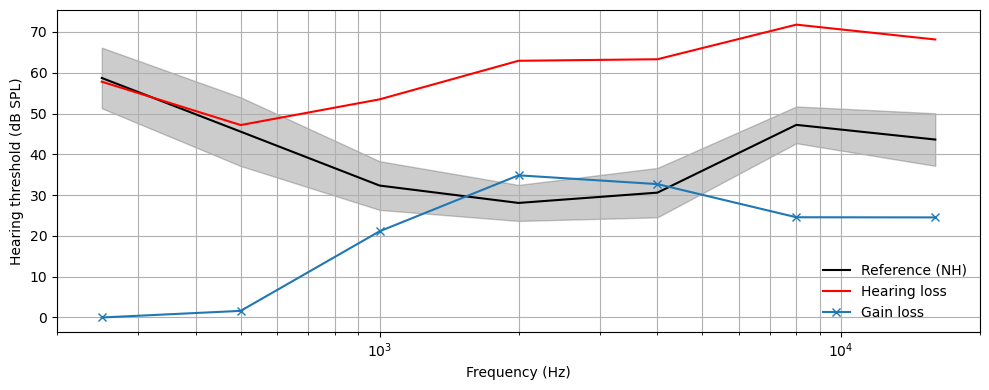

In [6]:
# Read the CSV file and extract columns
data = np.genfromtxt('AidNet/hearing_thresholds.csv', delimiter=',', skip_header=1)
freqs = data[:,0]
NH_mean = data[:,1]
NH_std = data[:,2]
HI_mean = data[:,3]
gain_loss = data[:,4]

plt.figure(figsize=(10,4))
# Plot the normal hearing thresholds
plt.semilogx(freqs, NH_mean, 'k', label='Reference (NH)')
plt.fill_between(freqs, NH_mean - NH_std, NH_mean + NH_std, color='k', alpha=0.2)
# Plot the thresholds of the example hearing-impaired animal and the corresponding gain loss
plt.semilogx(freqs, HI_mean, 'r', label='Hearing loss')
plt.semilogx(freqs, gain_loss, label='Gain loss', marker='x')

plt.grid(which='both')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hearing threshold (dB SPL)')
plt.legend(frameon=False)
plt.xlim(200, 20000)
plt.tight_layout()
plt.show()

## Prepare the audio input

In [7]:
# Read the wavfile and resample to the model sampling frequency
audio_input, fs_wavfile = wavfile_read(wavfile_path, fs_audio) # if an fs argument is provided, the wavfile gets resampled
assert len(audio_input.shape) == 1 or audio_input.shape[-1] == 1, "AidNet can only process monaural sounds for now"
# Calibrate to the desired sound level
audio_input = p0 * 10**(sound_level/20) * audio_input / rms(audio_input)
# Add context, segment to windows (if needed) and reshape into a 3D array
audio_input = slice_1dsignal(audio_input, window_size, winshift = window_size, left_context = context_size_left, right_context = context_size_right)
# The audio input needs to be a multiple of the downsampling factor
ds_factor = 2**n_encoder_layers
if audio_input.shape[1] % ds_factor:
    audio_input = pad_along_1dimension(audio_input,0,ds_factor - (audio_input.shape[1] % ds_factor), axis=1) # right padding with zeros
# Change the data type of the audio input (float32 is enough)
audio_input = audio_input.astype(np.float32)

## Process sound using AidNet

In [8]:
time_elapsed = time()
# Get the processed sound from AidNet
audio_output = process_audio(model_path, audio_input, **params) # print_summary=True, 
time_elapsed = time() - time_elapsed
print('Simulation finished in ' + '%.2f' % time_elapsed + ' s')

2026-01-27 09:46:12.291225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Simulation finished in 3.06 s


In [9]:
# Remove the context from the audio input and reshape to a 1D array
if context_size_left:
    audio_input = audio_input[:,context_size_left:]
if context_size_right:
    audio_input = audio_input[:,:-context_size_right]
audio_input = audio_input.flatten()
audio_output = audio_output.flatten()
# Define the time arrays
t_audio = np.arange(0., audio_input.size/fs_audio, 1./fs_audio)

## Plot the sound processing

In [10]:
# Time range to plot
time_range = [20,21.5] # seconds
# Mel spectrogram parameters
n_fft = 1024
hop_length = 32
win_length = 256
n_mels = 128
fmin = 50
fmax = 12000
top_db = 100

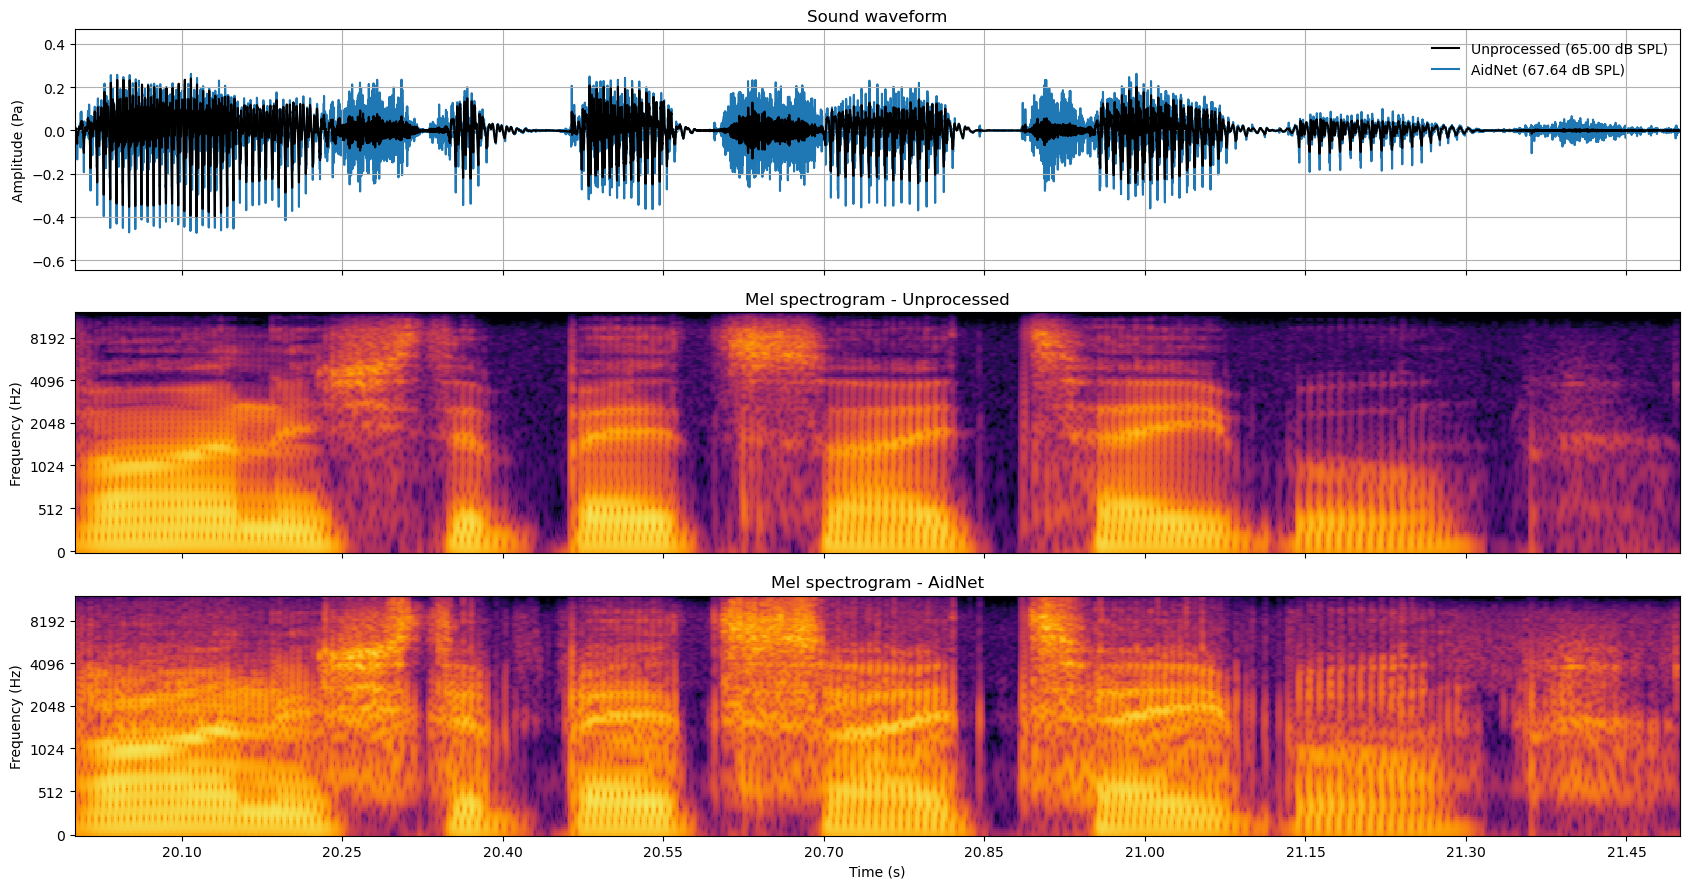

In [11]:
f, ax = plt.subplots(3,figsize=(17,9), sharex=True)
# Sound waveform
ax[0].set_title('Sound waveform')
ax[0].plot(t_audio,audio_input,'k',label='Unprocessed (%.2f dB SPL)' % (20*np.log10(rms(audio_input,None))-20*np.log10(p0)) )
ax[0].plot(t_audio,audio_output,zorder=0,label='AidNet (%.2f dB SPL)' % (20*np.log10(rms(audio_output,None))-20*np.log10(p0)) )
ax[0].grid();
ax[0].legend(frameon=False)
ax[0].set_ylabel('Amplitude (Pa)')

# Mel spectrogram
ax[1].set_title('Mel spectrogram - Unprocessed')
melspec = librosa.feature.melspectrogram(y=audio_input, sr=fs_audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref = p0 ** 2, top_db = top_db)
img = librosa.display.specshow(melspec, sr=fs_audio, hop_length=hop_length, cmap='inferno', ax=ax[1], x_axis='time', y_axis='mel');
ax[1].set_xlabel('')
ax[1].set_ylabel('Frequency (Hz)')
# f.colorbar(img, ax=ax[1], format="%2.f dB SPL", fraction=0.05) # colorbar

# Mel spectrogram
ax[2].set_title('Mel spectrogram - AidNet')
melspec = librosa.feature.melspectrogram(y=audio_output, sr=fs_audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref = p0 ** 2, top_db = top_db)
img = librosa.display.specshow(melspec, sr=fs_audio, hop_length=hop_length, cmap='inferno', ax=ax[2], x_axis='time', y_axis='mel');
ax[2].set_xlabel('')
ax[2].set_ylabel('Frequency (Hz)')
# f.colorbar(img, ax=ax[1], format="%2.f dB SPL", fraction=0.05) # colorbar

ax[2].set_xlabel('Time (s)')
ax[2].xaxis.set_major_formatter(ScalarFormatter())
if len(time_range):
    ax[2].set_xlim(time_range)

f.tight_layout();

In [12]:
## Save the audio output as a wavfile
wavfile_path_output = wavfile_path.replace('.wav','_aidnet.wav')
wavfile_write(audio_output, wavfile_path_output, fs_audio, fs_wavfile)

## Analyse the gain profile

In [13]:
## Define the parameters of the white noise stimuli that will be used to derive the transfer functions of AidNet
window_size = 65536
level_range = list(range(0,121,20))
## Make white noise at the specified levels
noise_inputs = np.zeros((len(level_range),window_size+context_size_left+context_size_right,1), dtype=np.float32)
for i_level, level in enumerate(level_range):
    stim = np.random.normal(size=window_size+context_size_left+context_size_right)
    stim_level = 20*np.log10(rms(stim,axis=None))-20*np.log10(2e-5)
    stim *= 10**(-(stim_level-level)/20)
    noise_inputs[i_level,:,0] = stim

In [14]:
time_elapsed = time()
# Get the processed sound from AidNet
noise_outputs = process_audio(model_path, noise_inputs, **params) # print_summary=True, 
time_elapsed = time() - time_elapsed
print('Simulation finished in ' + '%.2f' % time_elapsed + ' s')

Simulation finished in 1.03 s


In [15]:
# Remove the context from the audio input and reshape to a 1D array
if context_size_left:
    noise_inputs = noise_inputs[:,context_size_left:]
if context_size_right:
    noise_inputs = noise_inputs[:,:-context_size_right]
noise_inputs = noise_inputs[...,0]
noise_outputs = noise_outputs[...,0]
# Define the time arrays
t_audio = np.arange(0., noise_inputs.shape[1]/fs_audio, 1./fs_audio)

In [16]:
# Define the spectrum plotting parameters
spectrum_bands = 12
spectrum_flow = 20.
spectrum_fhigh = 12200.

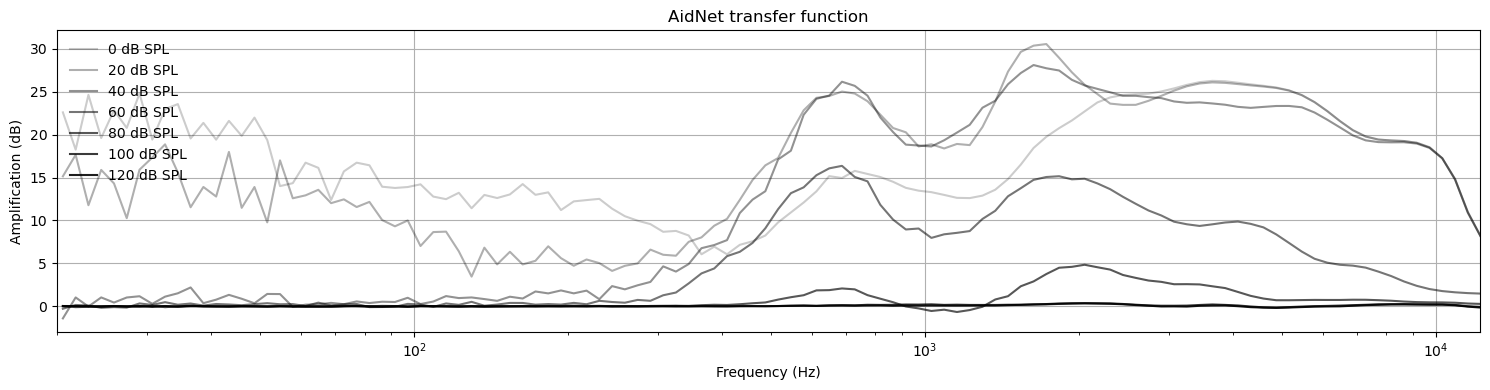

In [17]:
f = plt.figure(figsize=(15,4))

alpha = 0.2
for i_level, level in enumerate(level_range):
    freqs, spectrum = fractional_octaves(noise_inputs[i_level], fs_audio, density=True, start=spectrum_flow, stop=spectrum_fhigh, fraction=spectrum_bands)
    _, spectrum_processed = fractional_octaves(noise_outputs[i_level], fs_audio, density=True, start=spectrum_flow, stop=spectrum_fhigh, fraction=spectrum_bands)
    plt.semilogx(freqs.center, spectrum_processed - spectrum, 'k', alpha=alpha, label="%d dB SPL" % level)
    alpha += 0.8/len(level_range)
    
plt.grid();
plt.legend(frameon=False)
plt.title('AidNet transfer function')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplification (dB)')
plt.xlim(spectrum_flow,spectrum_fhigh)
f.tight_layout();